<a href="https://colab.research.google.com/github/RachelRamirez/misclassification_matrix/blob/main/PreExperiment_PA_Shfl_40D_Lambda1_Lambda2_Lambda3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreExperiment PA Shfl 40D Lambda1 Lambda2 Lambda3




In prior notebooks, I experimented with one variable; lambda, the value the cost-matrix takes on for whatever misclassification we are interested in.  The seeded neural network we trained using a normal cost-matrix of all ones usually had a higher misclassification count on the true 9s being mislabelled as 4s, which you will sometimes see written as "9T, 4P" or, "w[9t,4p]".

We changed the lambda values and allowed as many epochs of training with  early-stopping and a patience of 10 to conclude once training was beginnnig to overfit the validation data (also the test set).   Lambda values chosen were 1, 10, 100, and 1000.   These values were chosen because it seemed that only very high values like 1000 could drive down the number of misclassifications of 9T,4P to zero.

In this notebook, continuing to use a relatively balanced dataset, we're going to also experiment with a second variable, time of training.  This is a little more tricky to define because the variable lambda is thought to have an impact on the number of epochs needed.  Therefore if you have a certain lambda value in the beginning of training, you may only need 10 total epochs of training, but if you use it at the end of training, you may need more epochs of training.  In addition there is the question as to whether we should define   a static number of epochs or to allow early stopping.  

As an example:


|Lambda | Rep 1 Epochs | Rep 2 Epochs |  Rep 3 | Rep 4 |	Rep 5 |	Rep 6	| Rep 7	| Rep 8	|Rep 9	| Rep 10 |  Average of 10 Reps |
|-- | -- | --- |  --| -- |  --| -- |  --| -- |  --| -- |  --| 
1	|17|19|19|	22|	17	|21	|19	|22	|19|	22|	... 19*
100 |14|14|14|	11|	14	|14	|14	|14	|14|	14|	... 13.7*
1000:	|18|23|22|	35|	7	|25	|21	|19	|23|	24|	... 21.7

*However 1 and 100 were done with patience of 3, whereas 1000 was done with patience of 10 and more epochs.  Rerunning the 1's with the same patience appears to up the number of epochs til early stopping to mid-20s.  


We'll test the conditions for using a static training cycle first, because it's easier to code and report on, and then test how to do a dynamic training cycle, 


## Reduced  capacity neural network with two layers of 40 connections

  Filename "PA_Shfl_w[9,4]_2.0_40D_Misclassification_Cost_Matrix_Example"

#### Check timezone if incorrect restart

In [7]:
# How to change the local time in Google Colab
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Eastern /etc/localtime
!date

#If this doesn't show the local time correctly, then you need to restart.
import time
time.localtime(time.time())

Thu 02 Mar 2023 06:41:55 PM EST


time.struct_time(tm_year=2023, tm_mon=3, tm_mday=2, tm_hour=23, tm_min=41, tm_sec=56, tm_wday=3, tm_yday=61, tm_isdst=0)

### Reproducible Seeds

In [8]:
#For Reproducibility
import numpy as np
# np.random.seed(1337)  # for reproducibility

import tensorflow as tf
# tf.random.set_seed(33)

import random as python_random
# python_random.seed(4)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
tf.keras.utils.set_random_seed(342) #Possibly use next iteration if the above doesn't work


# Running more than once causes variation.  try adding this:
# Set seed value
seed_value = 56
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

print("TF version: " , tf.__version__ )
print("Keras version: " , tf.keras.__version__ )

TF version:  2.11.0
Keras version:  2.11.0


### Import rest of Library

In [9]:

# from https://github.com/keras-team/keras/issues/2115#issuecomment-204060456
# witha correction on the weighted function in the middle 

'''Train a simple deep NN on the MNIST dataset.
Get to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function  #do i still need this?
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools
from functools import partial
from time import ctime
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

## MORE REPEATABILITY STUFF NEEDED - If theres a way to update this to V2 of Tensorflow great, otherwise I had to use TF 1.0 code
# 5. Configure a new global `tensorflow` session (https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds)
# from keras import backend as K


#I believe thecode below is to help things be repeatable each time different sections in my google colab notebook execute
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

### Define batch, epochs, and format data

In [10]:
batch_size = 256 # I originally had it very  high batch size to reduce the variation in the data each batch and hope it makes the model training more nearly identical which it did, then i bring it back down to something reasonable to get better results training the NN
nb_classes = 10
nb_epoch = 45

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


11490434/11490434 [==============================] - 2s 0us/step
60000 train samples
10000 test samples


### Weighted Categorical Cross Entropy Class

In [11]:
class WeightedCategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):

  def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):

    cost_mat = np.array(cost_mat)   
    ## when loading from config, self.cost_mat returns as a list, rather than an numpy array. 
    ## Adding the above line fixes this issue, enabling .ndim to call sucessfully. 
    ## However, this is probably not the best implementation
    assert(cost_mat.ndim == 2)
    assert(cost_mat.shape[0] == cost_mat.shape[1])
    super().__init__(name=name, **kwargs)
    self.cost_mat = K.cast_to_floatx(cost_mat)

  def __call__(self, y_true, y_pred, sample_weight=None):
    assert sample_weight is None, "should only be derived from the cost matrix"  
    return super().__call__(
        y_true=y_true, 
        y_pred=y_pred, 
        sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
    )


  def get_config(self):
    config = super().get_config().copy()
    # Calling .update on the line above, during assignment, causes an error with config becoming None-type.
    config.update({'cost_mat': (self.cost_mat)})
    return config

  @classmethod
  def from_config(cls, config):
    # something goes wrong here and changes self.cost_mat to a list variable.
    # See above for temporary fix
    return cls(**config)

def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n


# Register the loss in the Keras namespace to enable loading of the custom object.
tf.keras.losses.WeightedCategoricalCrossentropy = WeightedCategoricalCrossentropy
 

### WeightedCategoricalCross Entropy Function 

In [16]:
def PA_method_epoch(cost_matrix, nb_epoch = 45, patience = 10 , **args):

  model3 = Sequential()
  model3.add(Dense(40, input_shape=(784,), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model3.add(Activation('relu'))
  model3.add(Dropout(0.2))
  model3.add(Dense(40, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model3.add(Activation('relu'))
  model3.add(Dropout(0.2))
  model3.add(Dense(10,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model3.add(Activation('softmax'))

  rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/

  model3.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=rms,  metrics='categorical_accuracy',)

  #https://www.tensorflow.org/tensorboard/image_summaries
  #I want to display the number of misclassifications for a certain value on the confusion matrix
  #this existing code is to display the confusion matrix as an image to tensorboard each epoch
  #I just need to use model.predict()
  #I convert to confusion matrix
  # and subset the confusion matrix to the right value
  # and print that value

  def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    y_prediction = model3.predict(X_test)
    y_prediction  = np.argmax(y_prediction, axis=1)

    #Create confusion matrix 
    cm = confusion_matrix(y_test, y_prediction)
    print(cm)
    print("4t,9p: ", cm[4,9])
    print("9t,4p: ", cm[9,4])
    # # Log the confusion matrix as an image summary.
    # with file_writer_cm.as_default():
    #   tf.summary.image("epoch_confusion_matrix", cm_image, step=epoch)

  # Define the per-epoch callback.
  cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)

  # # Print the batch number at the beginning of every batch.
  # batch_print_callback = tf.keras.callbacks.LambdaCallback(
  #     on_batch_begin=lambda batch,logs: print(batch))


  model3_history = model3.fit(X_train, Y_train,
            batch_size=batch_size, epochs=nb_epoch, verbose=2,
            validation_data=(X_test, Y_test), shuffle=True, use_multiprocessing=True
            ,callbacks = [es_callback, cm_callback]
            )

 

  #Predict
  y_prediction = model3.predict(X_test)
  y_prediction  = np.argmax(y_prediction, axis=1)
  # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)

  #Create confusion matrix and normalizes it over predicted (columns)
  # result = confusion_matrix(y_test, y_prediction , normalize='pred')

  

  cm3 = confusion_matrix(y_test, y_prediction)
  cm3 = pd.DataFrame(cm3, range(10),range(10))
  # plt.figure(figsize = (10,10))
  # cm3
  # sns.heatmap(cm2, annot=True, annot_kws={"size": 12}) # font size
  # plt.show()
  # cm_using_weighted_new = cm3

  # print(model3_history.history)
  tot_epochs = max(model3_history.epoch)+1  #if the total epochs ran is 28, it'll show up as 27 in the epoch object so we must add 1
  print("Total Epochs: ", tot_epochs)

  #if tot_epochs is the total number of epochs ran then early stop did not happen, and we need not minus patience
  if tot_epochs == nb_epoch:
    restored_weights = tot_epochs
  else:
    restored_weights  = tot_epochs-patience   #when using restore-best-weights and patience, it'll restore the best weights back
  print("Restored weights at ", restored_weights)
  


  #Label is the epoch weights are restored 
  label = f"{restored_weights}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value = f"{ model3_history.history['val_categorical_accuracy'][restored_weights]}"
  print("Label: ", label, "Val_Cat_Acc Value: ", label_value)



  plt.plot(range(1,tot_epochs+1), model3_history.history['categorical_accuracy'],)
  plt.plot(range(1,tot_epochs+1), model3_history.history['val_categorical_accuracy'])
  plt.xlim(xmin=1)

  plt.scatter((restored_weights), model3_history.history['val_categorical_accuracy'][restored_weights-1] , color='orange')

  plt.annotate(text=label,  xy=(restored_weights, model3_history.history['val_categorical_accuracy'][restored_weights-1]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch (starts at 1)')

  
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  

  plt.plot(range(1,tot_epochs+1), model3_history.history['loss'])
  plt.plot(range(1,tot_epochs+1), model3_history.history['val_loss'])
  plt.xlim(xmin=1)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch (starts at 1)')
  plt.legend(['train', 'val'], loc='upper left')
  plt.scatter(restored_weights, model3_history.history['val_loss'][restored_weights-1])
  plt.annotate(text=label,  xy=(restored_weights, model3_history.history['val_loss'][restored_weights-1]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')
  plt.show()




  return cm3, model3_history, model3

### *Keep Track of Experimental Admin Stuff - #Runs and #CostMatrix

> Change the cost matrix and number of runs and check the file extension name 


#### *Define Cost Matrix and Method

In [13]:
# Experimental Admin Stuff
cost_matrix = np.ones((10,10))

### Weight of Misclassification
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cost_matrix[9, 4] = 1
cost_str = str(cost_matrix[9, 4])
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



### File Extension to reference in JMP : weights_method_cost
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
file_extension = "w[9,4]_PA_" + cost_str + "_Shfl_40D_"
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)

print("Last run using ", cost_str)

Last run using  1.0


#### Run Experiments

Run  1 Starting with a  cost_matrix[9, 4] =  1000.0  for 45 epochs with Early Stopping and Restore Best Weights ... 
Epoch 1/45
313/313 [==============================] - 2s 6ms/step
[[ 930    0    1    2    0    7   21    1   15    3]
 [   0 1094   17    3    0    0    4    0   15    2]
 [  13   11  872   29    0    1   23   10   52   21]
 [   3    3   31  873    0   36    1   12   27   24]
 [   5    7    5    0   60    4   19    3   13  866]
 [  12    2    7   34    1  714   16   10   68   28]
 [  25    4   13    0    2   13  888    2   10    1]
 [   0   42   11    5    2    0    1  819   10  138]
 [  14   23   16   19    4   39   11    9  781   58]
 [   9    6    2   11    0    4    1   22    6  948]]
866
0
235/235 - 5s - loss: 2.3161 - categorical_accuracy: 0.6047 - val_loss: 0.5747 - val_categorical_accuracy: 0.7979 - 5s/epoch - 21ms/step
Epoch 2/45
313/313 [==============================] - 2s 7ms/step
[[ 955    0    0    1    0    6   12    1    5    0]
 [   0 1106    5    4    

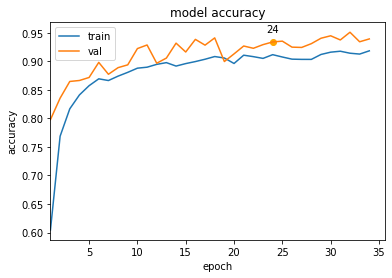

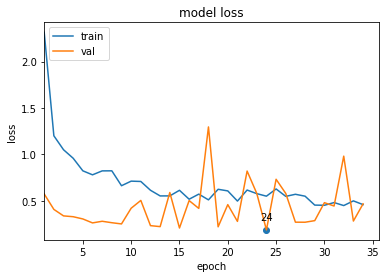

After first stage CM: 
      0     1    2    3    4    5    6    7    8    9
0  965     0    2    2    0    2    5    2    2    0
1    0  1118    3    3    0    0    3    1    7    0
2    7     5  969    8    3    1    6   14   16    3
3    0     1    9  968    0   10    0   12    7    3
4    1     0    2    1  654    0   10    2    7  305
5    4     0    0   14    1  843   10    3   13    4
6    5     4    1    0    4   10  932    0    2    0
7    3    11    7    5    1    0    0  989    1   11
8    6     4    3    8    3    5    6    4  930    5
9    4     6    0   10    0    8    0    6    4  971
After first stage CM[9,4]: 
 0


In [17]:
#@title
cm = np.zeros([10,10])
combined_cms = np.empty((1,100))

combined_history_dictionary = {}  #because there will be a unknown number of epochs a dictionary is probly a better fit
combined_history_list       = []


## Define the total number of runs
### ~~~~~~~~~
runs = 1
### ~~~~~~~~~~

#its easier for me to count my runs as "1 and up" instead of 0...   
for i in range(1,runs+1):
  cost_matrix[9, 4] = 1000
  print("Run ", i, "Starting with a  cost_matrix[9, 4] = ",  cost_matrix[9, 4] , " for 45 epochs with Early Stopping and Restore Best Weights ... ")


  cm2 , history, model =  PA_method_epoch(cost_matrix,nb_epoch=45 )    #Individual CM, and Training/Validation History
  print("After first stage CM: \n", cm2)

  print("After first stage CM[9,4]: \n", cm2[4][9])
  


  combined_history_dictionary[i] = history
  combined_history_list.append(history)
  # cm += cm2                   #Aggregating for an Average
  cm2_array = np.asarray(cm2)  #Indiv CM as array for storing
  combined_cms = np.vstack((combined_cms,cm2_array.reshape((1,100))))

# ###############################
# ## Code to update the fitted model with the new cost matrix
# ###############################

# cost_matrix[9, 4] = 1000

# print("Run ", i, " continued, with a  cost_matrix[9, 4] = ",  cost_matrix[9, 4] , " for 45 epochs and Early Stopping on Val_Loss of patience 20 ... ")


# rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/
# patience  = 20

# model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=rms,  metrics='categorical_accuracy',)
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)
# model_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2,
#               validation_data=(X_test, Y_test), shuffle=True, use_multiprocessing=True,callbacks = [callback])



# #Predict
# y_prediction = model.predict(X_test)
# y_prediction  = np.argmax(y_prediction, axis=1)



# cm3 = confusion_matrix(y_test, y_prediction)
# cm3 = pd.DataFrame(cm3, range(10),range(10))
# cm3

# #Label is the epoch weights are restored 
# label = f"{max(model_history.epoch)-patience}"

 
# plt.plot(model_history.history['categorical_accuracy'])
# plt.plot(model_history.history['val_categorical_accuracy'])
# plt.scatter(x=(max(model_history.epoch)-patience), y=model_history.history['val_categorical_accuracy'][max(model_history.epoch)-patience])

# plt.annotate(text=label,  xy=(max(model_history.epoch)-patience, model_history.history['val_categorical_accuracy'][max(model_history.epoch)-patience]),
#                 textcoords="offset points", 
#                 xytext=(0,10), 
#                 ha='center')
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')


# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


# plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.scatter(x=(max(model_history.epoch)-patience), y=model_history.history['val_loss'][max(model_history.epoch)-patience])
# plt.annotate(text=label,  xy=(max(model_history.epoch)-patience, model_history.history['val_loss'][max(model_history.epoch)-patience]),
#                 textcoords="offset points", 
#                 xytext=(0,10), 
#                 ha='center')
# plt.show()

# print("After second stage CM: \n", cm3)

# print("After second stage CM[9,4]: \n",cm3[4][9])  #First number is COLUMN, second number is ROW so column 4 is Prediction is 4, Row 9 is Truly a Label 9
  

#######

# cm_new = cm/30

In [12]:
# dir(history) and # print(history.__dict__)  are useful for digging into what variables are inside a variable

In [4]:
# combined_history_dictionary[1].history['loss'] #inside each combined_history_dictionary is a list
# combined_history_dictionary[1].history['val_loss']
# combined_history_dictionary[1].history['categorical_accuracy']
# combined_history_dictionary[1].history['val_categorical_accuracy']
# combined_history_dictionary[1].epoch

# len(combined_history_dictionary)  # the length is 1, but the dictionary starts at 1
# # len(combined_history_list)      # the length is 1, but the list starts at 0
# combined_history_list[0].history['loss'][17:19]
# combined_history_list[0].history['val_loss'][18-1]  #epoch 18 is where my first run stopped aand restored weights.  Epoch 18 is #17 with base 0 counting.


(combined_history_dictionary[1].history.keys())

NameError: ignored

In [14]:
# I need to remove the first placeholder row of zeros
combined_cms = combined_cms[1:(runs+1)]

#### Save the 30/X confusion matrices

In [17]:
#Save 30 confusion matrices

import pickle

str_runs = str(runs)


from datetime import date
from datetime import datetime
today = date.today()
file_date = today.strftime("%Y_%m_%d")
now = datetime.now() # current date and time
file_time = now.strftime("%H%M")
print("time:", file_time)




file_name = str_runs + "CM_" + file_extension + "_" + file_date + "_" + file_time +  "_.pkl"
print(file_name, " will be saved with ", combined_cms.shape)

with open(file_name, 'wb') as file_write:
      
    # A new file will be created
    pickle.dump(combined_cms, file_write)



 
# Open the file in binary mode
with open(file_name, 'rb') as file:
      
    # Call load method to deserialze
    var = pickle.load(file)
  
    print(var)
    
print(file_name, " was opened with ", var.shape)

from google.colab import files
files.download( file_name )  

print(file_name, ".pkl was saved to Downloads ")


time: 1522
1CM_w[9,4]_PA_1.0_Shfl_40D__2023_03_02_1522_.pkl  will be saved with  (1, 100)
[[ 962.    0.    2.    0.    1.    4.    7.    1.    3.    0.    0. 1114.
     3.    4.    0.    1.    3.    2.    8.    0.    7.    2.  974.    8.
     1.    1.    5.    9.   19.    6.    0.    1.   16.  943.    1.   24.
     0.   11.   12.    2.    1.    1.    5.    0.  675.    0.   18.    0.
     3.  279.    4.    0.    1.   12.    1.  850.   12.    2.    5.    5.
     9.    3.    0.    0.    4.   11.  928.    0.    3.    0.    4.    8.
    17.    2.    0.    0.    0.  982.    1.   14.    5.    5.    8.    7.
     5.   21.    9.    6.  901.    7.    8.    4.    0.   13.    3.    9.
     0.   12.    3.  957.]]
1CM_w[9,4]_PA_1.0_Shfl_40D__2023_03_02_1522_.pkl  was opened with  (1, 100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1CM_w[9,4]_PA_1.0_Shfl_40D__2023_03_02_1522_.pkl .pkl was saved to Downloads 


In [18]:
# How many categories are there in the test set?

truth_num_per_category = Y_test.sum(axis=0)
print(truth_num_per_category)

[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


# Analyze 

I am now going to load the Average CM and try to get it in a format where I can make it a 1x100 and load all 30 CMs so that we can visualize their distributions in a a big histogram_matrix. At this point the Google Colab variables are gone and I have to reoad them 

In [19]:
import numpy as np
import pandas as pd
empty_cm = np.zeros((10,10))  
empty_cm=pd.DataFrame(empty_cm)

empty_cm.columns = ['0p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p']
empty_cm.index = ['0t', '1t', '2t', '3t', '4t', '5t', '6t', '7t', '8t', '9t']

# print(myvar_cm_average)

empty_cm_array = np.asarray(empty_cm)
empty_cm_array_1_100 = np.reshape(empty_cm_array,(1,100))
# print(cm_average_array)

df = empty_cm
df_new = pd.DataFrame(empty_cm_array_1_100,  columns=pd.MultiIndex.from_product([ df.index,df.columns]))
df_new.columns.to_flat_index()
df_new.columns   = ['_'.join(col) for col in df_new.columns.values]

# Now convert combined_cms of size 30x100 to a panda dataframe
combined_cms_df = pd.DataFrame(combined_cms, columns=[df_new.columns])

combined_cms_df

,0t_0p,0t_1p,0t_2p,0t_3p,0t_4p,0t_5p,0t_6p,0t_7p,0t_8p,0t_9p,...,9t_0p,9t_1p,9t_2p,9t_3p,9t_4p,9t_5p,9t_6p,9t_7p,9t_8p,9t_9p
0,962.0,0.0,2.0,0.0,1.0,4.0,7.0,1.0,3.0,0.0,...,8.0,4.0,0.0,13.0,3.0,9.0,0.0,12.0,3.0,957.0


In [20]:
combined_cms_df["9t_4p"]

,9t_4p
0,3.0


In [21]:
np.average(combined_cms_df["9t_4p"])

3.0

In [22]:
csv_filename = file_name[:-4] + ".csv"

combined_cms_df.to_csv(csv_filename)


from google.colab import files
files.download(csv_filename )

print("Downloading ", csv_filename , " of shape ", combined_cms_df.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
df = pd.DataFrame(sum(var)/len(var), columns=["Values"]) 
# print(df)

df.style.format({
  'Values': lambda val: f'{val:,.2f}',
})

(df.sort_values(by="Values", ascending=False)[0:20])


df_sorted = df.sort_values(by="Values", ascending=False)[10:]  #the top 10 are usually diagonal


df_sorted.style.format({
  'Values': lambda val: f'{val:,.2f}',
})

import math

print("On average...")
print("Num 1 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[0])/10), " as a ", df_sorted["Values"].index[0]%10, "  (", (df_sorted["Values"].values[0]), " times)" )
print("Num 2 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[1])/10), " as a ", df_sorted["Values"].index[1]%10, "  (", (df_sorted["Values"].values[1]), " times)" )
print("Num 3 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[2])/10), " as a ", df_sorted["Values"].index[2]%10, "  (", (df_sorted["Values"].values[2]), " times)" )




On average...
Num 1 misclassifications are misclassifying a  4  as a  9   ( 279.0  times)
Num 2 misclassifications are misclassifying a  3  as a  5   ( 24.0  times)
Num 3 misclassifications are misclassifying a  8  as a  5   ( 21.0  times)


In [24]:
df_percents = pd.DataFrame( ((sum(var)*100/len(var)).reshape((10,10))/truth_num_per_category).reshape((100)), columns = ["Values"])


df_sorted_percents = df_percents.sort_values(by="Values", ascending=False)[10:]  #the top 10 are usually diagonal

df_sorted_percents.style.format({
  'Values': lambda val: f'{val:,.2f}',
})

print("On average .. ")
print("Num 1 percent misclassifications", math.floor((df_sorted_percents["Values"].index[0])/10), " as ", df_sorted_percents["Values"].index[0]%10, (df_sorted_percents["Values"].values[0]), " percent" )
print("Num 2 percent misclassifications", math.floor((df_sorted_percents["Values"].index[1])/10), " as ", df_sorted_percents["Values"].index[1]%10,  (df_sorted_percents["Values"].values[1]), " percent" )
print("Num 3 percent misclassifications", math.floor((df_sorted_percents["Values"].index[2])/10), " as ", df_sorted_percents["Values"].index[2]%10, (df_sorted_percents["Values"].values[2]), " percent" )






On average .. 
Num 1 percent misclassifications 4  as  9 27.651139742319128  percent
Num 2 percent misclassifications 3  as  5 2.690582959641256  percent
Num 3 percent misclassifications 8  as  5 2.3542600896860986  percent


# Extraneous

To reference later: 

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb#scrollTo=UJ589fn8ST3x

To train a model with class weights:

```
class_weight = {0: weight_for_0, 1: weight_for_1}

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),

    # The class weights go here
    class_weight=class_weight)
```



In [25]:
# Extraneous information I am not using at the moment

# model.compile(
#      optimizer='adam',
#      loss=WeightedCategoricalCrossentropy(cost_matrix)
#      )

## Model Saving

# model.save(save_version_dir,save_format='tf')

## Model Loading

# model = tf.keras.models.load_model(
#     save_version_dir,
#     compile=True,
#     custom_objects={
#         'WeightedCategoricalCrossentropy': WeightedCategoricalCrossentropy(cost_matrix)
#         }
#     )
 

starting to think about how i would shape the initial, middle and late training experiments.  

In [26]:
count = 0


print("     | --- Init --- | | --- Mid --- | | --- Late --- | ")
for i in ["   1"," 100", "1000"]:
  for j in  ["   1"," 100", "1000"]:
    for k in   ["   1"," 100", "1000"]:
      count+=1
      print(f"{count}    |     {i}     ,     {j}    ,    {k}     | ")




     | --- Init --- | | --- Mid --- | | --- Late --- | 
1    |        1     ,        1    ,       1     | 
2    |        1     ,        1    ,     100     | 
3    |        1     ,        1    ,    1000     | 
4    |        1     ,      100    ,       1     | 
5    |        1     ,      100    ,     100     | 
6    |        1     ,      100    ,    1000     | 
7    |        1     ,     1000    ,       1     | 
8    |        1     ,     1000    ,     100     | 
9    |        1     ,     1000    ,    1000     | 
10    |      100     ,        1    ,       1     | 
11    |      100     ,        1    ,     100     | 
12    |      100     ,        1    ,    1000     | 
13    |      100     ,      100    ,       1     | 
14    |      100     ,      100    ,     100     | 
15    |      100     ,      100    ,    1000     | 
16    |      100     ,     1000    ,       1     | 
17    |      100     ,     1000    ,     100     | 
18    |      100     ,     1000    ,    1000     | 
19    |     1000 